In [1]:
import pandas as pd
import numpy as np
#import pickle
import optuna.integration.lightgbm as lgb
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import logging

/Users/dirk/Anaconda/anaconda3/envs/nd025/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read the cleaned dataset
df = pd.read_parquet('./data/cleaned_dataset.parquet')

In [3]:
df.sample(10)

,MESS_DATUM,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,MONTH,SEASON
87981,1968-10-17,12.5,1.0,NaN,0.0,4.7,10.1,NaN,8.6,89.0,13.3,7.3,5.5,10,Autumn
170940,1996-01-28,0.0,0.0,4.8,0.0,2.3,2.8,1023.4,-6.1,74.0,-2.5,-10.8,-14.2,1,Winter
82769,1967-03-18,3.7,8.0,2.5,0.0,7.7,7.7,994.0,3.9,94.0,7.0,1.6,3.4,3,Spring
134256,1983-09-24,1.0,6.0,NaN,0.0,4.3,11.8,NaN,16.7,68.0,22.7,5.5,2.9,9,Autumn
205254,2010-06-12,0.1,6.0,NaN,0.0,6.7,13.5,NaN,15.6,76.0,18.6,11.6,9.5,6,Summer
191761,2004-03-11,0.0,4.0,NaN,NaN,NaN,6.0,1014.8,4.4,71.0,7.4,2.5,1.2,3,Spring
69707,1963-05-07,NaN,NaN,NaN,NaN,NaN,8.1,NaN,13.3,56.0,17.8,6.1,2.2,5,Spring
124311,1980-05-26,0.0,0.0,NaN,0.0,6.7,10.0,NaN,12.7,67.0,17.6,8.3,5.9,5,Spring
25577,1941-01-05,0.0,7.0,0.0,4.0,8.0,2.8,NaN,-7.4,78.0,-5.0,-9.0,NaN,1,Winter
59948,1960-05-18,0.0,0.0,7.8,0.0,7.0,16.8,1003.5,18.4,81.0,23.3,14.2,13.9,5,Spring


The idea is to use data from 1940 to 1970 for training and testing the classifier, data starting from 2000 to see whether the quality of classifications changed.\
How would this split look like?

In [4]:
# Train und test the classifier on data from 1940 to 1970
df.MESS_DATUM.dt.year.value_counts().sort_index().loc[1940:1970].sum()

70032

70032 measurements are in the timespan 1940 - 1970 

In [5]:
# Use data from 2000 onwards to test the hypothesis
df.MESS_DATUM.dt.year.value_counts().sort_index().loc[2000:].sum()

45418

45418 measurements are in the timespan 2000 - today

In [6]:
df_past = df[(df.MESS_DATUM.dt.year >= 1940) & (df.MESS_DATUM.dt.year <= 1970)]
df_current = df[(df.MESS_DATUM.dt.year >= 2000)]

Is the dataset balanced, i.e. do we have roughly the same number of measuremnt in each season?

In [7]:
df_past.groupby(by='SEASON').count()

,MESS_DATUM,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,MONTH
SEASON,,,,,,,,,,,,,,
Autumn,17472,13559,13559,6506,12831,13190,17467,9039,17467,17464,17472,17472,15759,17472
Spring,17597,13732,13732,6440,12997,13353,17597,9071,17597,17595,17597,17597,15877,17597
Summer,17634,13708,13708,6470,12972,13335,17634,9078,17634,17633,17634,17634,15886,17634
Winter,17329,13507,13507,6380,12785,13139,17272,8954,17329,17265,17329,17329,15568,17329


In [8]:
df_current.groupby(by='SEASON').count()

,MESS_DATUM,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,MONTH
SEASON,,,,,,,,,,,,,,
Autumn,11284,11280,11280,6201,8470,7250,11259,6897,11282,11259,11282,11281,11275,11284
Spring,11473,11460,11459,6528,8553,7332,11454,7140,11473,11453,11468,11468,11457,11473
Summer,11408,11405,11405,6323,7329,7299,11372,7042,11408,11372,11408,11408,11387,11408
Winter,11253,11253,11253,6351,8997,7191,11244,6970,11252,11244,11253,11253,11246,11253


In both, the past and current dataset, we see a that there are roughly the same number of measurements for each season. Also the size of the two sets is large enough to proceed.

In [9]:
# Define features and labels 
X = df_past.drop(columns=['MESS_DATUM', 'MONTH', 'SEASON'])
y = df_past['SEASON']

# Encode the seasons
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

We have timeseries data here. It's not a good idea to use the *train_test_split* function. Using that function would put information from the future into the training set.  
In this case it's better to select timeframes for training, validation and test. (80% train, 20 % test and 20% of train for validation)

In [10]:
# Create train, validation and test sets
X_train, X_test, y_train, y_test = X[:len(X) * 4 // 5], X[len(X) * 4 // 5 + 1:], y[:len(y) * 4 // 5], y[len(y) * 4 // 5 + 1:]
X_train, X_valid, y_train, y_valid = X_train[:len(X_train) * 4 // 5], X_train[len(X_train) * 4 // 5 + 1:], y_train[:len(y_train) * 4 // 5], y_train[len(y_train) * 4 // 5 + 1:]

# Create datasets for lightgbm
lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train, free_raw_data=False)
lgb_test = lgb.Dataset(X_test, y_test, free_raw_data=False)

In [11]:
# Set parameters for the lightgbm classifier
params = {
            "objective": "multiclass",
            "metric": "auc_mu",
            "boosting_type": "gbdt",
            "num_class": 4,
            "seed": 42
        }

record={}
study = optuna.create_study(direction='maximize')

logger = logging.getLogger("LightGBM") 
logger.setLevel(logging.DEBUG) 
formatter = logging.Formatter('%(levelname)s | %(message)s') 
log_filename = "./LightGBM_logger.log" 
file_handler = logging.FileHandler(log_filename, mode="w", encoding="utf-8") 
file_handler.setLevel(logging.DEBUG) 
file_handler.setFormatter(formatter) 
logger.addHandler(file_handler) 

lgb.register_logger(logger)

# Train the classifier. Hyperparameter tuning is done by optune, because we imported optuna.integration.lightgbm as lgb
model = lgb.train(
                    params,
                    lgb_train,
                    valid_sets=[lgb_eval],
                    callbacks=[lgb.early_stopping(stopping_rounds=10)],
                    show_progress_bar = False,
                    study=study
                )

[I 2022-10-05 12:58:27,780] A new study created in memory with name: no-name-9fcb0115-f84c-4f69-a650-53521b7bc7c3
[I 2022-10-05 12:58:28,650] Trial 0 finished with value: 0.9198381511698908 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.9198381511698908.
[I 2022-10-05 12:58:29,561] Trial 1 finished with value: 0.9198381511698908 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.9198381511698908.
[I 2022-10-05 12:58:30,399] Trial 2 finished with value: 0.9198381511698908 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.9198381511698908.
[I 2022-10-05 12:58:31,116] Trial 3 finished with value: 0.9198381511698908 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.9198381511698908.
[I 2022-10-05 12:58:31,911] Trial 4 finished with value: 0.9198381511698908 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.9198381511698908.
[I 2022-10-05 12:58:32,969] Trial 5 

In [12]:
fig = optuna.visualization.plot_optimization_history(study, target_name='AUC')
fig.show()

In [13]:
study.best_trial

FrozenTrial(number=55, values=[0.9201054768859387], datetime_start=datetime.datetime(2022, 10, 5, 12, 59, 28, 535493), datetime_complete=datetime.datetime(2022, 10, 5, 12, 59, 29, 265400), params={'lambda_l1': 0.003385776323673523, 'lambda_l2': 1.5095949738627801e-06}, distributions={'lambda_l1': LogUniformDistribution(high=10.0, low=1e-08), 'lambda_l2': LogUniformDistribution(high=10.0, low=1e-08)}, user_attrs={}, system_attrs={'lightgbm_tuner:elapsed_secs': 0.7242870330810547, 'lightgbm_tuner:average_iteration_time': 0.016461068933660335, 'lightgbm_tuner:step_name': 'regularization_factors', 'lightgbm_tuner:lgbm_params': '{"objective": "multiclass", "metric": "auc_mu", "boosting_type": "gbdt", "num_class": 4, "seed": 42, "feature_pre_filter": false, "lambda_l1": 0.003385776323673523, "lambda_l2": 1.5095949738627801e-06, "num_leaves": 31, "feature_fraction": 0.8, "bagging_fraction": 0.5145272360098033, "bagging_freq": 5, "min_child_samples": 20}'}, intermediate_values={}, trial_id=55,

In [14]:
# Predict the labels of the testset
prediction = model.predict(X_test, num_iteration=model.best_iteration)

# Compute accuracy, F1-score and auc
accuracy = accuracy_score(y_test, prediction.argmax(axis=1))
f1 = f1_score(y_test, prediction.argmax(axis=1), average='weighted')
auc = roc_auc_score(y_test, prediction, multi_class='ovo')

print("Accuracy = {}".format(accuracy))
print("F1-Score = {}".format(f1))
print(f"The ROC AUC of loaded model's prediction is: {auc:.3f}")

Accuracy = 0.6891332286163073
F1-Score = 0.6772236401991016
The ROC AUC of loaded model's prediction is: 0.901


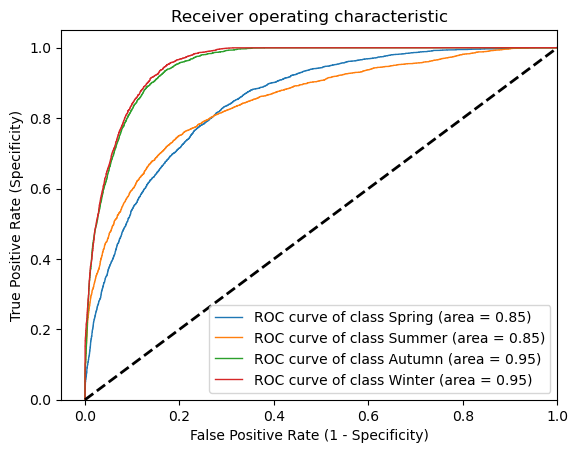

In [15]:
from sklearn.metrics import auc
def plot_roc(y_true, y_pred, num_classes, class_names):
    """Computes the ROC curve for each class and plots one diagram with all ROC curves

    Arguments:
        y_true -- array of the correct predictions
        y_pred -- array of the predicted probabilities for the classes; shape (len(y_true), num_classes)
        num_classes -- number of classes
        class_names -- names of the num_classes classes
    """
    assert len(class_names) == num_classes, 'Number of classes does not match number of class names.'

    # Dictionaries for the false positive rate, true prositive rate and auc
    fpr = dict()
    tpr = dict()
    roc_auc = dict()


    # For each class compute the fpr, tpr and auc
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true, y_pred[:, i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    # Plot the curve with a different color for each class
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=1,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(class_names[i], roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Specificity)')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

plot_roc(y_test, prediction, 4, ['Spring', 'Summer', 'Autumn', 'Winter'])


* Sensitivity: The probability that the model predicts a positive outcome for an observation when the outcome is indeed positive.
* Specificity: The probability that the model predicts a negative outcome for an observation when the outcome is indeed negative.


In [16]:
# Take the current data of the dataset and use the classifier to predict
X_current = df_current.drop(columns=['MESS_DATUM', 'MONTH', 'SEASON'])
y_current = df_current['SEASON']

# Encode the seasons
le = preprocessing.LabelEncoder()
y_current = le.fit_transform(y_current)

# Predict the labels of the dataset
pred_current = model.predict(X_current, num_iteration=model.best_iteration)

# Compute accuracy, F1-score and auc
accuracy_current = accuracy_score(y_current, pred_current.argmax(axis=1))
f1_current = f1_score(y_current, pred_current.argmax(axis=1), average='weighted')
auc_current = roc_auc_score(y_current, pred_current, multi_class='ovo')

print(f"Accuracy = {accuracy_current:.3f}")
print(f"F1-Score = {f1_current:.3f}")
print(f"The ROC AUC of loaded model's prediction is: {auc_current:.3f}")


Accuracy = 0.664
F1-Score = 0.647
The ROC AUC of loaded model's prediction is: 0.886


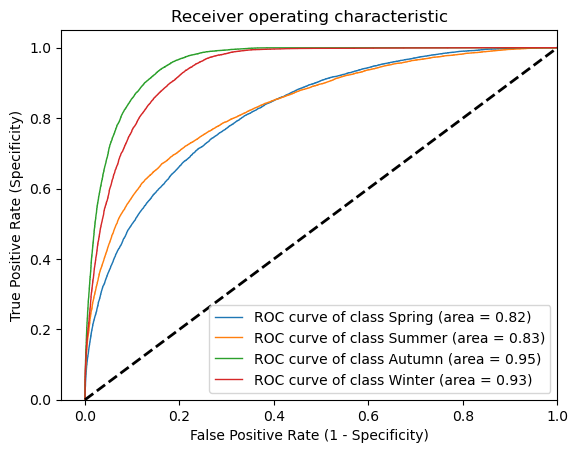

In [17]:
plot_roc(y_current, pred_current, 4, ['Spring', 'Summer', 'Autumn', 'Winter'])

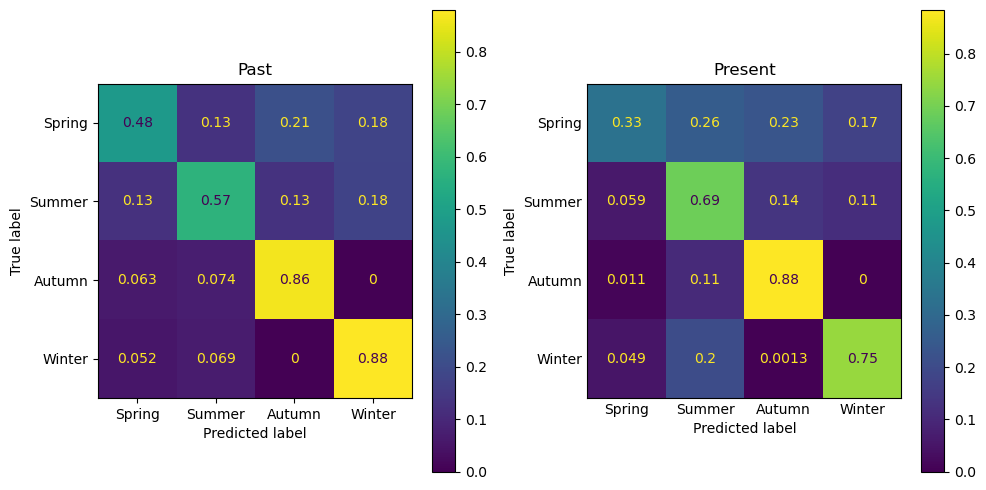

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].set_title("Past")
ax[1].set_title("Present")
ax[0].grid(False)
ax[1].grid(False)

ConfusionMatrixDisplay(
                        confusion_matrix = confusion_matrix(y_true=y_test, y_pred=prediction.argmax(axis=1), normalize='true'),
                        display_labels = ['Spring', 'Summer', 'Autumn', 'Winter']
                      ).plot(ax=ax[0])
plt.tick_params(axis=u'both', which=u'both',length=0)

ConfusionMatrixDisplay(
                        confusion_matrix = confusion_matrix(y_true=y_current, y_pred=pred_current.argmax(axis=1), normalize='true'),
                        display_labels = ['Spring', 'Summer', 'Autumn', 'Winter']
                      ).plot(ax=ax[1])
plt.tick_params(axis=u'both', which=u'both',length=0)

plt.tight_layout()
plt.show()


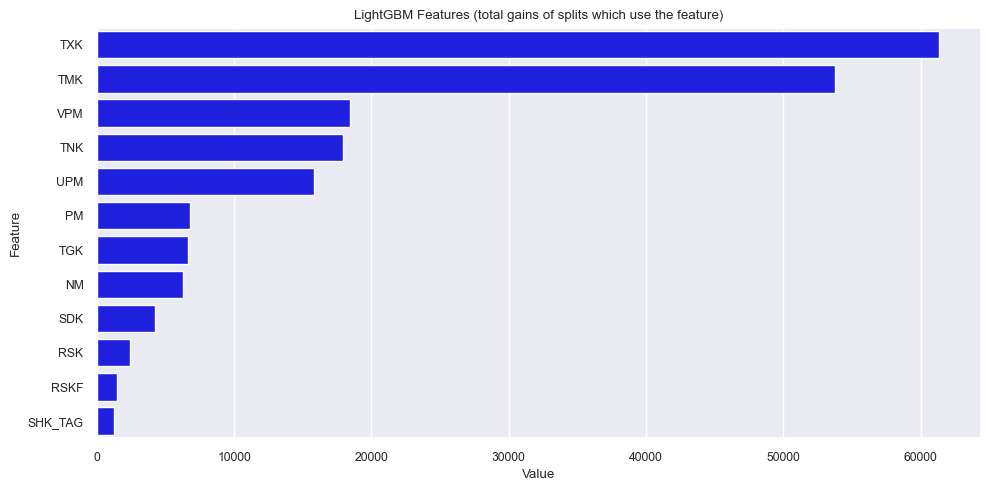

In [19]:
def plot_feature_importance(model, X , num = 20, fig_size = (10, 5)):
    """Plot a bar chart of the feature importances

    Arguments:
        model -- The model 
        X -- The features

    Keyword Arguments:
        num -- Maximum number of features in the chart (default: {20})
        fig_size -- Size of the figure (default: {(10, 5)})
    """
    feature_imp = pd.DataFrame({'Value':model.feature_importance(importance_type='gain'),
                                'Feature':model.feature_name()})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = .8)
    sns.barplot(x="Value", y="Feature", color='blue',
                data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title('LightGBM Features (total gains of splits which use the feature)')
    plt.tight_layout()
    plt.show()

plot_feature_importance(model, X_train)


<Figure size 2000x1000 with 0 Axes>

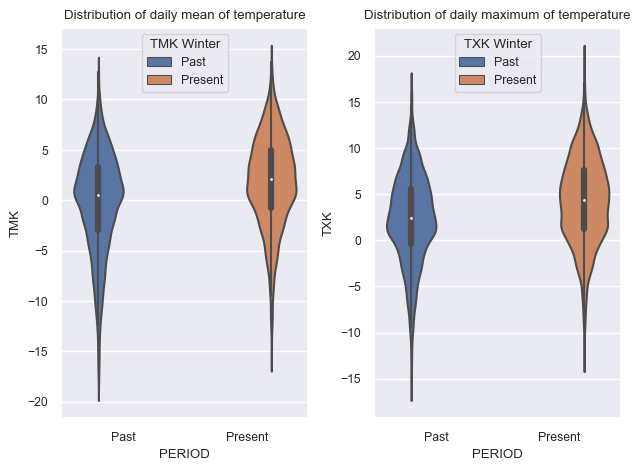

In [20]:
df_past = df_past.assign(PERIOD='Past', YEAR=df_past.MESS_DATUM.dt.year)
df_current = df_current.assign(PERIOD='Present', YEAR=df_current.MESS_DATUM.dt.year)

dp = df_past.loc[df_past.SEASON == 'Winter', ['TMK', 'TXK', 'PERIOD', 'YEAR']]
dc = df_current.loc[df_current.SEASON == 'Winter', ['TMK', 'TXK', 'PERIOD', 'YEAR']]

df_all = pd.concat([dp,dc], axis=0, ignore_index=True)
df_all.reset_index(drop=True)

plt.figure(figsize=(20,10))

fig, axs = plt.subplots(ncols=2)

axs[0].set_title('Distribution of daily mean of temperature')
sns.violinplot(df_all, x=df_all.PERIOD, y=df_all.TMK, hue=df_all.PERIOD, ax=axs[0])
axs[0].legend(loc="upper center", title="TMK Winter", title_fontsize="medium")

axs[1].set_title('Distribution of daily maximum of temperature')
sns.violinplot(df_all, x=df_all.PERIOD, y=df_all.TXK, hue=df_all.PERIOD, ax=axs[1])
axs[1].legend(loc="upper center", title="TXK Winter", title_fontsize="medium")

plt.tight_layout()
plt.show()

<Figure size 2000x1000 with 0 Axes>

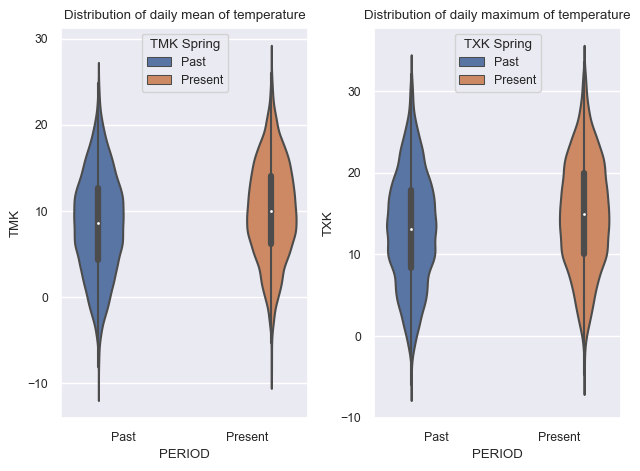

In [21]:
df_past = df_past.assign(PERIOD='Past', YEAR=df_past.MESS_DATUM.dt.year)
df_current = df_current.assign(PERIOD='Present', YEAR=df_current.MESS_DATUM.dt.year)

dp = df_past.loc[df_past.SEASON == 'Spring', ['TMK', 'TXK', 'PERIOD', 'YEAR']]
dc = df_current.loc[df_current.SEASON == 'Spring', ['TMK', 'TXK', 'PERIOD', 'YEAR']]

df_all = pd.concat([dp,dc], axis=0, ignore_index=True)
df_all.reset_index(drop=True)

plt.figure(figsize=(20,10))

fig, axs = plt.subplots(ncols=2)

axs[0].set_title('Distribution of daily mean of temperature')
sns.violinplot(df_all, x=df_all.PERIOD, y=df_all.TMK, hue=df_all.PERIOD, ax=axs[0])
axs[0].legend(loc="upper center", title="TMK Spring", title_fontsize="medium")

axs[1].set_title('Distribution of daily maximum of temperature')
sns.violinplot(df_all, x=df_all.PERIOD, y=df_all.TXK, hue=df_all.PERIOD, ax=axs[1])
axs[1].legend(loc="upper center", title="TXK Spring", title_fontsize="medium")

plt.tight_layout()
plt.show()

<Figure size 2000x1000 with 0 Axes>

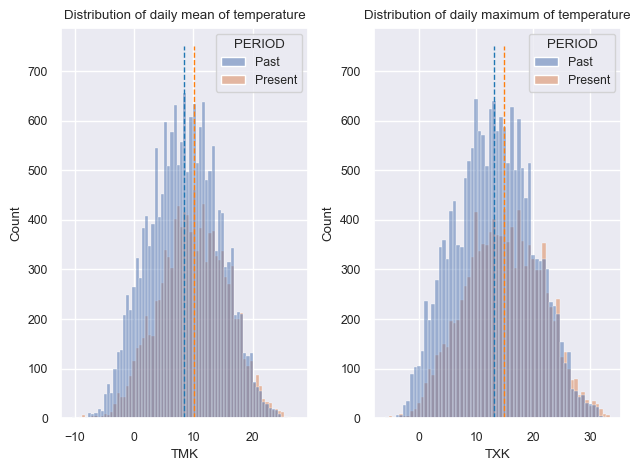

In [22]:
means = df_all[['TXK', 'TMK', 'PERIOD']].groupby(by=['PERIOD']).mean()

plt.figure(figsize=(20,10))

fig, axs = plt.subplots(ncols=2)

axs[0].set_title('Distribution of daily mean of temperature')
sns.histplot(df_all, x=df_all.TMK, ax=axs[0], hue=df_all.PERIOD)
axs[0].vlines(x=[means.loc['Past','TMK'], means.loc['Present','TMK']], ymin=0, ymax=750, colors=['tab:blue', 'tab:orange'], ls='--', lw=1, alpha=1)

axs[1].set_title('Distribution of daily maximum of temperature')
sns.histplot(df_all, x=df_all.TXK,  ax=axs[1], hue=df_all.PERIOD)
axs[1].vlines(x=[means.loc['Past','TXK'], means.loc['Present','TXK']], ymin=0, ymax=750, colors=['tab:blue', 'tab:orange'], ls='--', lw=1, alpha=1, label='mean')

plt.tight_layout()
plt.show()

Both TMK and TXK have a distribution similar to a normal distribution. That's relevant for the upcoming test. The test will show whether the shift of the means (vertical lines) is significant.

$H_{0-TMK}$: The mean of the winter TMK distribution in the interval 1940 - 1970 is the same as in the interval 2000 - today.  
$H_{a-TMK}$: The mean of the winter TMK distribution in the interval 1940 - 1970 is different from the on in the interval 2000 - today.

$H_{0-TXK}$: The mean of the winter TMX distribution in the interval 1940 - 1970 is the same as in the interval 2000 - today.  
$H_{a-TXK}$: The mean of the winter TMX distribution in the interval 1940 - 1970 is different from the on in the interval 2000 - today.

In [23]:
from scipy import stats

a = dp['TMK'].to_numpy()
b = dc['TMK'].to_numpy()

c = dp['TXK'].to_numpy()
d = dc['TXK'].to_numpy()

#perform Welch's t-test
# Alternative hypothesis: 'two-sided': the means of the distributions underlying the samples are unequal.
print(stats.ttest_ind(a=a, b=b, equal_var=False, nan_policy='omit', alternative='two-sided'))
print(stats.ttest_ind(a=c, b=d, equal_var=False, nan_policy='omit', alternative='two-sided'))

Ttest_indResult(statistic=-22.844295284131178, pvalue=2.450207719275157e-114)
Ttest_indResult(statistic=-22.330531399357866, pvalue=2.2905374345706266e-109)


* A pvalue of 2.45e-114 allows us to reject $H_{0-TMK}$  
* A pvalue of 2.29e-109 allows us to reject $H_{0-TXK}$  

Both, the daily maximum of temperature at 2m height and the daily mean of temperature in winter changed significantly.